In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import tensorflow as tf
import time
import scipy

import collections, numpy

import data_loader as dl
import data_transformer as dt

from sklearn.cluster import KMeans
from keras.utils import to_categorical

from sklearn.utils import shuffle

from final.model import Model
from final.helpers import Helpers

class ModelHelpers:
    @staticmethod
    @tf.custom_gradient
    def clip_grad_layer(x):
        def grad(dy):
            return tf.clip_by_value(dy, 1e-10, 1e-10)
        return tf.identity(x), grad
    
    @staticmethod
    def input_placeholders(max_len, input_columns):
        X = tf.placeholder(tf.float32, [None, max_len, input_columns], name="X")
        input_mask = tf.placeholder(tf.bool, [None, max_len], name="input_mask")
        return X, input_mask

    @staticmethod
    def labels_placeholders(max_len, n_clusters, n_angles):
        y = tf.placeholder(tf.float32, [None, max_len, n_clusters], name='y')
        y_angles = tf.placeholder(tf.float32, [None, max_len, n_angles], name='y_angles')
        return y, y_angles

    @staticmethod
    def clusters(init_clusters, trainable=False, clip_value = 1, clip_gradient_eps=False):
        clusters_tf = tf.Variable(initial_value=init_clusters, dtype=np.float32, trainable=trainable)
        clusters_tf = tf.clip_by_value(clusters_tf, -clip_value, clip_value)
        if clip_gradient_eps:
            clusters_tf = ModelHelpers.clip_grad_layer(clusters_tf)
        return clusters_tf  

Using TensorFlow backend.


In [2]:
# change this path to match the path of where you have the
# training_50 and validation files
txt_data_path = '/home/mikey/Data/ProteinNet/casp7_txt/'

max_len = None # max len of the protein taken into account
n_angles = 2 # 3 if consider all angles or 2 if only phi and psi

The data_lim is important because so far the full 13000 proteins crashes my system with 16Gb of ram

Load training data

In [3]:
file_name = 'training_50'
data_lim = 6000
prim_train, evo_train, dih_train, mask_train = (dl.parse_primary_from_file(txt_data_path + file_name, data_lim), 
                                                dl.parse_evolutionary_from_file(txt_data_path + file_name, data_lim),
                                                dl.load_file('./'+file_name+'_dih.joblib'),
                                                dl.parse_mask_from_file(txt_data_path + file_name, data_lim))
dih_train = dih_train[:data_lim]
len(prim_train), prim_train[0].shape, len(evo_train), evo_train[0].shape, len(dih_train), dih_train[0].shape, len(mask_train), mask_train[0].shape

Loaded data and filtered line endings
Extracted primary data
Encoded primary sequences
Loaded data and filtered line endings
Extracted evolutionary data


100%|██████████| 6000/6000 [00:00<00:00, 74142.52it/s]


Grouped 21's together
Loaded data and filtered line endings
Extracted mask data


(6000, (70, 20), 6000, (70, 21), 6000, (70, 3), 6000, (70,))

Load validation data

In [4]:
file_name = 'validation'
prim_valid, evo_valid, dih_valid, mask_valid = (dl.parse_primary_from_file(txt_data_path + file_name), 
                                                dl.parse_evolutionary_from_file(txt_data_path + file_name),
                                                dl.load_file('./'+ file_name + '_dih.joblib'),
                                                dl.parse_mask_from_file(txt_data_path + file_name))
len(prim_valid), prim_valid[0].shape, len(evo_valid), evo_valid[0].shape, len(dih_valid), dih_valid[0].shape, len(mask_valid), mask_valid[0].shape

Loaded data and filtered line endings
Extracted primary data
Encoded primary sequences
Loaded data and filtered line endings
Extracted evolutionary data


100%|██████████| 224/224 [00:00<00:00, 67330.09it/s]

Grouped 21's together
Loaded data and filtered line endings
Extracted mask data


(224, (269, 20), 224, (269, 21), 224, (269, 3), 224, (269,))

Pad the data and limit protein length. Prepare the data for training

In [5]:
prim_, evo_, dih_, mask_ = dt.limit_length_and_pad(prim_train, evo_train, dih_train, mask_train, max_len)
x_train, y_train = np.concatenate([prim_, evo_], axis=2), dih_[:,:,:n_angles]
prim_v, evo_v, dih_v, mask_v = dt.limit_length_and_pad(prim_valid, evo_valid, dih_valid, mask_valid, max_len)
x_valid, y_valid = np.concatenate([prim_v, evo_v], axis=2), dih_v[:,:,:n_angles]

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

padded
(6000,) (70, 20)
padded
(6000,) (70, 21)
padded
(6000,) (70, 3)
padded
(6000,) (70, 1)
padded
(224,) (269, 20)
padded
(224,) (269, 21)
padded
(224,) (269, 3)
padded
(224,) (269, 1)


((6000, 1733, 41), (6000, 1733, 2), (224, 696, 41), (224, 696, 2))

In [6]:
def ang_to_vec(angles):
    res = []
    for i in range(angles.shape[-1]):
        angles_cos = np.cos(angles[:,:,i])
        angles_sin = np.sin(angles[:,:,i])
        angles_stacked = np.stack([angles_cos, angles_sin], axis=-1)
        res.append(angles_stacked)
    return np.concatenate(res, axis=-1)

y_train_angles = y_train
y_valid_angles = y_valid
y_train = ang_to_vec(y_train)
y_valid = ang_to_vec(y_valid)
y_train.shape, y_valid.shape

((6000, 1733, 4), (224, 696, 4))

In [7]:
select_clusters_n = 50
km = KMeans(n_clusters=select_clusters_n, random_state=0, verbose=0, max_iter=1000).fit(y_train[:200].reshape(-1,n_angles*2))
clusters = km.cluster_centers_
n_clusters = clusters.shape[0]
clusters.shape

(50, 4)

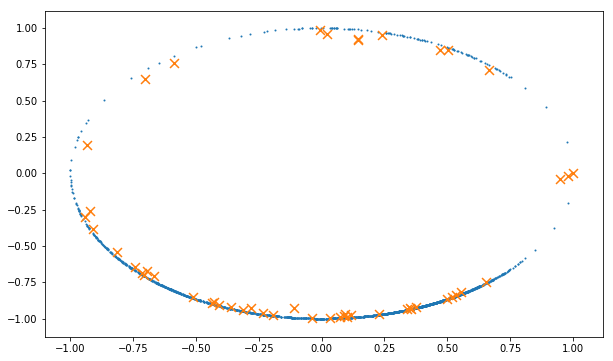

In [8]:
def plot_cluster_centers(data, clusters, x_i, y_i, data_lim=10):
    plt.figure(figsize=(10,6))
    plt.scatter(y_valid[:data_lim][:,:,x_i], y_valid[:data_lim][:,:,y_i], s=1)
    plt.scatter(clusters[:,x_i], clusters[:,y_i], marker='x', s=80)
    
plot_cluster_centers(y_valid, clusters, x_i=0, y_i=1, data_lim=10)
if n_angles == 3:
    plot_cluster_centers(y_valid, clusters, x_i=1, y_i=2, data_lim=10)
    plot_cluster_centers(y_valid, clusters, x_i=0, y_i=2, data_lim=10)

In [9]:
y_train_labels_ = np.argmin(scipy.spatial.distance_matrix(y_train.reshape(-1,n_angles*2), clusters), 
                            axis=1).reshape(y_train.shape[0], y_train.shape[1])

y_valid_labels_ = np.argmin(scipy.spatial.distance_matrix(y_valid.reshape(-1,n_angles*2), clusters), 
                            axis=1).reshape(y_valid.shape[0], y_valid.shape[1])

y_train_labels = to_categorical(y_train_labels_, num_classes=n_clusters)
y_valid_labels = to_categorical(y_valid_labels_, num_classes=n_clusters)

y_train_labels.shape, y_valid_labels.shape, np.unique(y_train_labels_), np.unique(y_valid_labels_), n_clusters

((6000, 1733, 50),
 (224, 696, 50),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 50)

In [10]:
def load_config(config):
    return config['mode'], config['loss_mode']

config1 = {'mode': 'regression', 'loss_mode': 'angular_mae'}

config2 = {'mode': 'vectors','loss_mode': 'angular_mae'}

config3 = {'mode': 'vectors','loss_mode': 'normal_mae'}

config4 = {'mode': 'clusters','loss_mode': 'angular_mae'}

config5 = {'mode': 'clusters','loss_mode': 'normal_mae'}

In [11]:
mode, loss_mode = load_config(config5)

vec_on_unit_circle = False
if not mode == 'regression':
    if loss_mode == 'normal_mae':
        vec_on_unit_circle = False
    else:
        vec_on_unit_circle = True

tf.reset_default_graph()  

X, input_mask = ModelHelpers.input_placeholders(max_len = max_len, input_columns = 41)
y, y_vectors = ModelHelpers.labels_placeholders(max_len, n_clusters, n_angles*2)
y, y_angles = ModelHelpers.labels_placeholders(max_len, n_clusters, n_angles)
# y_vectors = tf.placeholder(max_len, n_clusters, n_angles, 2)

clusters_tf = ModelHelpers.clusters(init_clusters=clusters, trainable=True, clip_gradient_eps=False)

# construct the feature extraction part of the network
dropout = 0.3
core_out = Model.CoreModels.resnet1d_big(X, 0.4)

### Regression ###
rad_pred = tf.zeros_like(y_angles)
if mode == 'regression':
    rad_pred_cont = tf.layers.dense(core_out, n_angles)# angles logits
    rad_pred = Helpers.angularize(rad_pred_cont)

### Regression ###
vec_pred = tf.zeros_like(y_angles)
if mode == 'vectors':
    if vec_on_unit_circle:
        activation = 'tanh'
    else:
        activation = 'linear'
    vec_pred = tf.layers.dense(core_out, n_angles * 2, activation=activation) # angles logits

    vec_pred_r = tf.reshape(vec_pred, shape=(-1, tf.shape(vec_pred)[1], n_angles, 2)) # reshape to 2 numbers (vector) per angle
    vec_loss_reg = tf.reduce_mean(tf.square(1 - (vec_pred_r[:,:,:,0] ** 2 + vec_pred_r[:,:,:,1]**2)))
#     vec_pred = vec_pred / (tf.expand_dims(tf.sqrt(vec_pred[:,:,:,0]**2 + vec_pred[:,:,:,1]**2), 3)+1) # normalize
    rad_pred = tf.atan2(vec_pred_r[:,:,:,0], vec_pred_r[:,:,:,1]) # convert vector to angle

logits = tf.layers.dense(core_out, n_clusters) # cluster logits
logits = tf.layers.dropout(logits, rate=0.05)
y_pred = tf.nn.softmax(logits)

# apply mask to all outputs used for losses (beware that the mask flattens them automatically)
y_masked, logits_masked, y_pred_masked, y_vectors_masked, y_angles_masked, rad_pred_masked, vec_pred_masked =\
    Helpers.mask_all([y, logits, y_pred, y_vectors, y_angles, rad_pred, vec_pred], input_mask)

### Clusters ###
# computes the weighted sum of clusters (weighted by the predicted prob. dist.)
if mode == 'clusters':
    vec_pred_masked = tf.einsum('ij,bi->bj', clusters_tf, y_pred_masked)
    vec_pred_masked_r = tf.reshape(vec_pred_masked, shape=(-1,n_angles,2))
    vec_loss_reg = tf.reduce_mean(tf.square(1 - (vec_pred_masked_r[:,:,0] ** 2 + vec_pred_masked_r[:,:,1]**2)))
    rad_pred_masked = tf.atan2(vec_pred_masked_r[:,:,1], vec_pred_masked_r[:,:,0])

# crossentropy loss on the classification task
clusters_crossentropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_masked, logits=logits_masked))

# mae computed for each angle separately
# mae_vec = tf.reduce_mean(tf.abs(tf.subtract(rad_pred_masked[:,:], y_angles_masked[:,:])), axis=0)

# mae reduced to 1 number
mae = tf.constant(0)
if not mode == 'regression':
    mae = tf.reduce_mean(tf.abs(tf.subtract(vec_pred_masked, 
                                            y_vectors_masked)))

# angular mae
mae_angles_vec = Helpers.loss360(rad_pred_masked, y_angles_masked)
mae_angles = tf.reduce_mean(mae_angles_vec)    

loss = {
    'normal_mae': mae,
    'angular_mae': mae_angles,
    'classification': clusters_crossentropy,
#     'angular_mae_and_classification': mae_ang + clusters_crossentropy
}[loss_mode]

regularization = []
if vec_on_unit_circle:
    regularization.append(vec_loss_reg)
    
if len(regularization) > 0:
    loss = tf.add_n([loss] + regularization)

# Define the optimizer operation
learning_rate = tf.placeholder(tf.float32)

# we can choose if we want to optimize mae or loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# Variables for prediction and accuracy
prediction = tf.argmax(y_pred_masked, 1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, tf.argmax(y_masked, 1)), tf.float32))

# Initialize the variables (they are assigned default values)
init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

n_parameters = np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])
print("Number of parameters:", n_parameters)

/home/mikey/.local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Number of parameters: 775130


In [12]:
# batch_size = 32
# init_learning_rate = 0.001
# with tf.Session() as session:

#     # Run the initializer
#     session.run(init)
#     b=0
#     loss_value = session.run([clusters_crossentropy], feed_dict={X: x_train[b:b+batch_size],
#                                                               y: y_train_labels[b:b+batch_size],
#                                                               y_vectors: y_train[b:b+batch_size],
#                                                               learning_rate: init_learning_rate,
#                                                             input_mask: mask_[b:b+batch_size]})

In [103]:
def pearson_numpy(y_true, y_pred):
    n_angles = y_true.shape[-1]
    a_angles = np.split(np.cos(y_true.reshape(-1,)).reshape(-1,n_angles), 
                                     indices_or_sections=n_angles, axis=-1)
    b_angles = np.split(np.cos(y_pred.reshape(-1,)).reshape(-1,n_angles),
                                     indices_or_sections=n_angles, axis=-1)
    return [scipy.stats.pearsonr(a.reshape(-1,), b.reshape(-1,))[0] for a,b in zip(a_angles, b_angles)]

batch_size = 32
n_epochs = 500

# Start as session
init_learning_rate = 0.001
with tf.Session() as session:

    # Run the initializer
    session.run(init)

    # Training cycle
    for epoch in range(n_epochs):
        print("Epoch:", epoch)
        train_loss = []
        for b in range(0, x_train.shape[0], batch_size):
            _, loss_value = session.run([optimizer, loss], feed_dict={X: x_train[b:b+batch_size],
                                                                      y: y_train_labels[b:b+batch_size],
                                                                      y_vectors: y_train[b:b+batch_size],
                                                                      y_angles: y_train_angles[b:b+batch_size],
                                                                      learning_rate: init_learning_rate,
                                                                    input_mask: mask_[b:b+batch_size]})
#             print(loss_value)
            train_loss.append(loss_value)
        
        (validation_accuracy, loss_, pred_, 
         clusters_, y_pred_masked_, mae_angles_,
        rad_pred_masked_, y_angles_masked_, core_out_,
        clusters_tf_) = session.run([accuracy, loss, prediction, 
                                                              clusters_tf, y_pred_masked, mae_angles,
                                                               rad_pred_masked, y_angles_masked, core_out,
                                   clusters_tf], 
                                                              feed_dict={X: x_valid, y: y_valid_labels, 
                                                                         y_vectors:y_valid,
                                                                         y_angles: y_valid_angles,
                                                                        input_mask: mask_v})
        x_train, y_train_labels, y_train, y_train_angles, mask_ = \
            Helpers.unison_shuffled_copies_sklearn([x_train, y_train_labels, y_train, y_train_angles, mask_])
        
#         print("val. loss = %f, val_acc = %f" % (loss_value, validation_accuracy))    
        print("Train loss = %f" % np.mean(train_loss))
        print("Valid loss =", loss_)
        print("PCC", pearson_numpy(rad_pred_masked_, y_angles_masked_))
        print(collections.Counter(pred_))
#         print(np.mean(y_pred_masked_, axis=0)) # prob. dist mean over clusters
#         print(np.max(y_pred_masked_, axis=0)) # prob. dist max over clusters
        print(init_learning_rate)
#         print(clusters_)
        
        # Shrinks the learning rate every n epochs
        train_loss = []
        if (epoch + 1) % 10 == 0:
            print("Adjusting learning rate")
            init_learning_rate = init_learning_rate / 1.05

Epoch: 0
Train loss = 0.387148
Valid loss = 0.3305084
PCC [0.4802013, 0.50347394]
Counter({26: 16315, 23: 6230, 9: 6068, 14: 5294, 15: 4680, 27: 1873, 13: 1735, 24: 1306, 43: 304, 10: 62})
0.001
-0.08414492
Epoch: 1
Train loss = 0.317366
Valid loss = 0.30236083
PCC [0.544332, 0.58738166]
Counter({26: 13707, 9: 12772, 10: 4108, 14: 3082, 15: 2135, 27: 1841, 24: 1839, 13: 1398, 23: 1109, 4: 713, 0: 703, 43: 333, 47: 127})
0.001
-0.08323164
Epoch: 2


KeyboardInterrupt: 

In [79]:
from sklearn.manifold import TSNE

to_tsne = core_out_[0:5]
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(to_tsne.reshape(-1,core_out_.shape[-1]))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 3480 samples in 0.024s...
[t-SNE] Computed neighbors for 3480 samples in 1.710s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3480
[t-SNE] Computed conditional probabilities for sample 2000 / 3480
[t-SNE] Computed conditional probabilities for sample 3000 / 3480
[t-SNE] Computed conditional probabilities for sample 3480 / 3480
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.877213
[t-SNE] KL divergence after 1000 iterations: 0.466702


In [82]:
tsne_results_2 = tsne_results.reshape((to_tsne.shape[0], to_tsne.shape[1], 2))

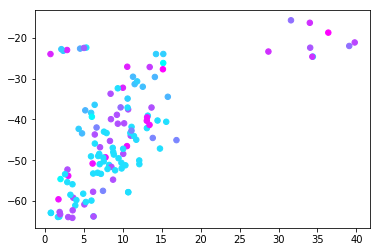

In [94]:
n = 4
mask = np.argmax(y_valid_labels[n], axis=1) != 0
plt.scatter(tsne_results_2[n][mask,0], tsne_results_2[n][mask,1], c=np.argmax(y_valid_labels[n][mask], axis=1), 
            s=30, cmap=plt.cm.cool)

0.6064993

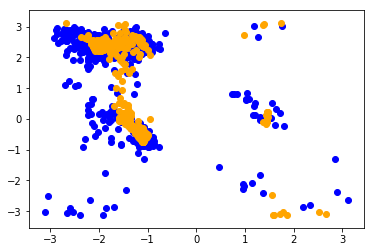

In [101]:
n = 500
plt.scatter(y_angles_masked_[:n,0], y_angles_masked_[:n,1], c='blue')
plt.scatter(rad_pred_masked_[:n,0], rad_pred_masked_[:n,1], c='orange')

np.mean(np.abs(y_angles_masked_ - rad_pred_masked_))

In [ ]:
np.min(rad_pred_), np.max(rad_pred_), np.min(rad_pred_cont_), np.max(rad_pred_cont_)

Organize model modes:
- predict angles through regression (tanh, *pi)
- predict clusters and optimize for crossentropy
- predict clusters and optimize for MAE
- predict clusters as vectors and optimize for MAE

In [ ]:
np.mean(np.abs(clusters_[pred_] - y_valid[mask_v])

resnet CNN filter_length = 15 (with 5 it didn't change much either)

*Rad angles, 10 not trainable clusters: 0.59

*Rad angles, 10 trainable clusters, no clipping: MAE [0.43384644 0.721744  ] 0.5777952

*Rad angles, 50 trainable clusters, no clipping: 
Train MAE = 0.545068
Val. MAE [0.43777448 0.7208223 ] 0.5792984

pcc: 58 70 (10000 proteins, cluster, angular_mae_and_classification)
pcc: 61.5 66.5 (10000 proteins, regression, angular_mae)